# <a href="https://miptstats.github.io/courses/ad_mipt.html">Phystech@DataScience</a>
## Семинар 3
## Аугментация и Transfer learning


In [ ]:
import os
import gc
import time
import glob
import requests
from tqdm.notebook import tqdm
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms

from IPython.display import clear_output
%matplotlib inline

sns.set(font_scale=1.2, style='whitegrid')

# device_num = 0
# torch.cuda.set_device(device_num)

In [ ]:
device = f"cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
print(device)

### 1. Аугментация <a id='augmentations'> </a>

![](https://sun9-5.userapi.com/c857216/v857216818/1815e6/OxQ8e3-o0oU.jpg)

**Дополнение данных / Аугментация данных / Data augmentations** &mdash; это метод, направленный на увеличение размеров обучающей выборки. Дополнение обучающей выборки разнообразными, "хорошими" и "плохими" примерами, позволяет получить модель более устойчивую на тестовых данных, так как для неё в тестовых данных будет меньше "неожиданностей".

Благодаря модулю `torchvision.transforms` агументации можно делать очень просто. Про все реализованные в библиотеке преобразования можно почитать [здесь](https://pytorch.org/vision/stable/transforms.html#transforms-scriptability). Мы рассмотрим наиболее распространенные классы аугментаций.

* `RandomAffine(degrees, translate=None, scale=None, shear=None, interpolation=<InterpolationMode.NEAREST: 'nearest'>, fill=0, fillcolor=None, resample=None)` &mdash; **случайное афинное преобразование** с сохранением центра. `degrees` &mdash; градус вращения. `translate` &mdash; смещение. `scale` &mdash; масштаб. Подробнее в документации.


* `ColorJitter(brightness=0, contrast=0, saturation=0, hue=0)` &mdash; *случайное* изменение **яркости** / brightness, **контраста** / contrast, **насыщенности** / saturation и **тонов** / hue цветов. Если на вход приходит torch.Tensor, то его размерность дожна быть `[..., 3, H, W]`. Если PIL.Image, то без альфа-канала. Каждый из параметров может быть быть задан в виде float числа: param, или пары float чисел: min, max. Значение парметра выбирается случайно из отрезка `[1 - param, 1 + param]` или `[min, max]` для brightness, contrast, saturation. Значение парметра должно быть нотрицательным. Значение парметра hue выбирается случайно из отрезка `[-hue, hue]` или `[min, max]`. При этом значение 0<= `hue <= 0.5` or `-0.5 <= min <= max <= 0.5`.  


* `CenterCrop(size)` &mdash; вырезает **прямоугольную область** размером `size[0] x size[1]`, если size задан туплом, если `size` задан числом &mdash; `size x size` **из центра картинки**.


* `GaussianBlur(kernel_size, sigma)` &mdash; *случайное* **гауссовское размытие изображения**. `kernel_size` &mdash; размер гауссовского ядра. `sigma` &mdash; стандартное отклонение. `sigma` может быть задано в виде чила, тогда парметр фиксирован, или в виде тупла in, max, тогда оно выбирается случайно из отрезка `[min, max]`.  


* `Grayscale(num_output_channels=1)` и `RandomGrayscale`(p=0.1) &mdash; неслучайная и *случайная* **трансформации картинки в ч/б формат**. Grayscale имеет парметр `num_output_channels`, который означет количество каналов на выходе, он может быть равен 1 или 3. RandomGrayscale имеет парметр p, который равен вероятности применения преобразования. Тензор на выхоже будет иметь столько же каналов, сколько тензор на входе.   


* `Normalize(mean, std, inplace=False)` &mdash; **нормализация тензора картинки** с заданными средним и отклонением для каждого канала. То есть `mean = (mean[1], ..., mean[n])`, `std = (std[1], ..., std[n])`, где `n` &mdash; количество каналов. Не поддерживает PIL.Image формат!   


* `RandomResizedCrop(size, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=<InterpolationMode.BILINEAR: 'bilinear'>)` &mdash; **случайное обрезание картинки** со случайным выбором размера и соотношения сторон и последующим **увеличеним картинки до первонального размера**.  

* `Resize(size, interpolation=<InterpolationMode.BILINEAR: 'bilinear'>)`  &mdash; **изменение размеров кратинки**. Если `size` задан числом, то наименьшая из размерностей картинки приобретает размер `size`. Иначе, если размер задан парой, то размер картинки становится равным `size[0] x size[1]`.

Для того, чтобы получить преобразование, которого нет в модуле torchvision.transforms можно использовать `Lambda` преобразование. Например, получить гауссовский шум на изображении можно так:
```
Lambda(lambda x : x + torch.randn_like(x))
```

Выше перечисленные трансформации применяются к данным типа PIL.Image или torch.Tensor,на выходе выдают соотвествующий формат. Для того, чтобы в через тарнсформации получить PIL.Image, можно использовать класс `ToPILImage`, для того, чтобы получить torch.Tensor &mdash; `ToTensor`. Эти классы в методе forward могут использовать torch.Tensor, np.ndarray и PIL.Image, np.ndarray соотвественно.

Чтобы объединить несколько трансформаций можно использовать `Compose`(transforms), где transforms &mdash; список из объектов коассов преобразований.

### Практика по аугментации

In [ ]:
from PIL import Image

In [ ]:
! wget https://www.kotzendes-einhorn.de/blog/wp-content/uploads/2011/01/lenna.jpg

In [ ]:
image = Image.open('./lenna.jpg')
image

Выберите  [отсюда](https://pytorch.org/vision/stable/transforms.html#transforms-on-pil-image-and-torch-tensor) 3 преобразования, прмените их к исходному изображению и объясните, что эти преобразования делают.

Пример применения:

In [ ]:
transform = transforms.RandomAffine(degrees=75)

transform(image)

In [ ]:
# ваше преобразование


In [ ]:
# ваше преобразование


In [ ]:
# ваше преобразование



### 2. Transfer Learning <a id=trans></a>

**Transfer Learning** &mdash; это процесс дообучения на *новых данных* какой-либо нейросети, предобученной до этого на других данных. Обычно предобучение производят на хорошем, большом  датасете размером около миллиона картинок, например, ImageNet ~ 14 млн картинок.

На данный момент есть множество предобученных моделей: `AlexNet`, `DenseNet`, `ResNet`, `VGG`, `Inception` и другие, а также их различные модификации. Все они отличаются архитектурой и входными данными.

#### 2.1 Описание метода:

Представим, что eсть новый набор данных, и вы хотите научить сеть классифицировать объекты из этой выборки.  

* **1. Fine Tuning / дообучение**  
   * Берём сеть, обученную на ImageNet.
   * Убираем последние Fully-Connected слои сети, отвечающие за классификацию.
   * Замораживаем веса только нескольких первых слоев сети (`param.requires_grad = False`). Последние веса оставляем обучаемыми.
   * Добавляем свои если если нужно. Например, пару FC-слоёв.
   * Обучаем получившуюся архитектуру на новых данных.

* **2. Feature Extractor / средство для извлечения признаков**
    * Берём сеть, обученную на ImageNet.
    * Убираем последние Fully-Connected слои сети, отвечающие за классификацию.
    * Замораживаем (`param.requires_grad = False`) веса всех предыдущих слоёв.
    * Добавляем свои сли если нужно. Например, пару FC-слоёв.
    * Обучаем на выходах полученной сети свой классификатор (пару FC-слоёв, например) на новых данных.

Ниже эти подходы изображены на примере VGG архитектуры:
    
<img src="https://sun9-66.userapi.com/c857632/v857632819/1ea161/rtU9L7NIrag.jpg" alt="tfl" width="600"/>

<style>
div.input {

В зависимости от количества и природы Ваших данных есть выбор из **нескольких стратегий Transfer Learning**, а именно:

* *У Вас **мало данных** ($\le 10k$), и они **похожи** на данные, на которых была обучена сеть до этого*  

    * если данные совсем похожи, можно попробовать использовать готовую модель
    * если качество Вас не устраивает, то тогда стоит обратиться к методу Feature Extractor
    * Fine Tuning лучше не использовать. Так как данные похожи на те, на которых обучалась сеть, то высокоуровневые признаки, полученные с помощью последних слоёв сети, должны оказаться информативными. Если делать в этом случае Fine-Tuning, то сеть может переобучиться, поскольку данных мало

* *У Вас **мало данных** ($\le 10k$), и они **не похожи** на данные, на которых была обучена сеть до этого*  
    * в данном случае мы *не можем* ожидать от сети, что выходы последних слоёв будут информативными для новых данных. Следует использовать Feature Extractor, но брать как признаки выходы более ранних слоёв. Ведь, как ожидается, они соответствуют более общим паттернам в данных.
* *У Вас **много данных** ($\ge 10k$), и они **похожи** на данные, на которых была обучена сеть до этого*  
    * можно попробовать использовать готовую модель
    * если качество Вас не устраивает, то тогда стоит cделать Fine-Tuning, ведь данных много, и вероятность переобучения меньше. Имеет смысл попробовать разморохить веса последних нескольких слоёв (можно разморозить и всю сеть)
* *У Вас **много данных** ($\ge 10k$), и они **не похожи** на данные, на которых была обучена сеть до этого*
    * Fine-Tuning практически всей сети. Веса предобученной сети оставляют в качестве инициализации для обучения на новых данных
    
display:none;
}
</style>

В зависимости от нового датасета имеет смысл использовать разные стратегии дообучения:
- если датасет *похож* на тот, на котором модель предобучена, то возможно стоит просто заменить слои классификации;
- если датасет *не похож*, то возможно стоит разморозить и сверточные слои тоже.

**Эмпирическое правило**: *чем больше новый датасет не похож* на тот, на котором обучали модель, *тем больше слоев с конца стоит размораживать*.

Если новый датасет достаточно большой (на каждый класс > 1000 изображений), то можно попробовать разморозить всю нейросеть и обучить со случайных весов, как мы это делали до того, как узнали про Transfer Learning.

Рассмотрим [**ResNet50**](https://arxiv.org/abs/1512.03385), предобученную на одном из самых крупных датасетов картинок ImageNet, который содержит 1000 классов. Подробнее про данный датасет можно почитать [здесь](http://image-net.org/).

Архитектура **ResNet50** основана на residual connections, которые позволяют избежать затухания градиентов:

![](https://sun9-72.userapi.com/c855620/v855620860/204ab7/DHbavFbU7QU.jpg)

#### 2.2 Изучение модели

Загрузим предобученную модель.

In [ ]:
from torchvision.models import resnet50

model = resnet50(pretrained=True)  # скачиваем предобученные веса

In [ ]:
model

Посмотрим на веса сверток на первом слое. Так как модель предобучена, то они веса уже имеют определенную структуру.

In [ ]:
# Минимальные и максимальные значения весов в слое.
max_val = model.conv1.weight.max().detach()
min_val = model.conv1.weight.min().detach()
# Нормировка весов для корректного отображения
weight = (model.conv1.weight - min_val) / (max_val - min_val)
print(f"Веса первого слоя ResNet50. Размер слоя: {weight.shape}")

plt.figure(figsize=(10, 10))
for i, filter in enumerate(weight):
    plt.subplot(8, 8, i + 1)
    plt.imshow(filter.permute(1, 2, 0).detach().cpu())
    plt.axis("off")

Кратко **объясните**, как вы понимаете то, что мы только что получили.

**Ответ:**

### 2.3 Transfer Learning на практике: СIFAR10

На прошлом семинаре мы строили свёрточную нейросеть для задачи классификации и обучали её на датасете СIFAR10. Напоминание: датасет состоит из 60k картинок 32х32х3.

50k &mdash; обучающая выборка, 10k &mdash; тестовая.

 ![](https://sun9-72.userapi.com/c857216/v857216523/12dbca/vdSCet5LS_0.jpg)

У вас должны были получиться подобные результаты:

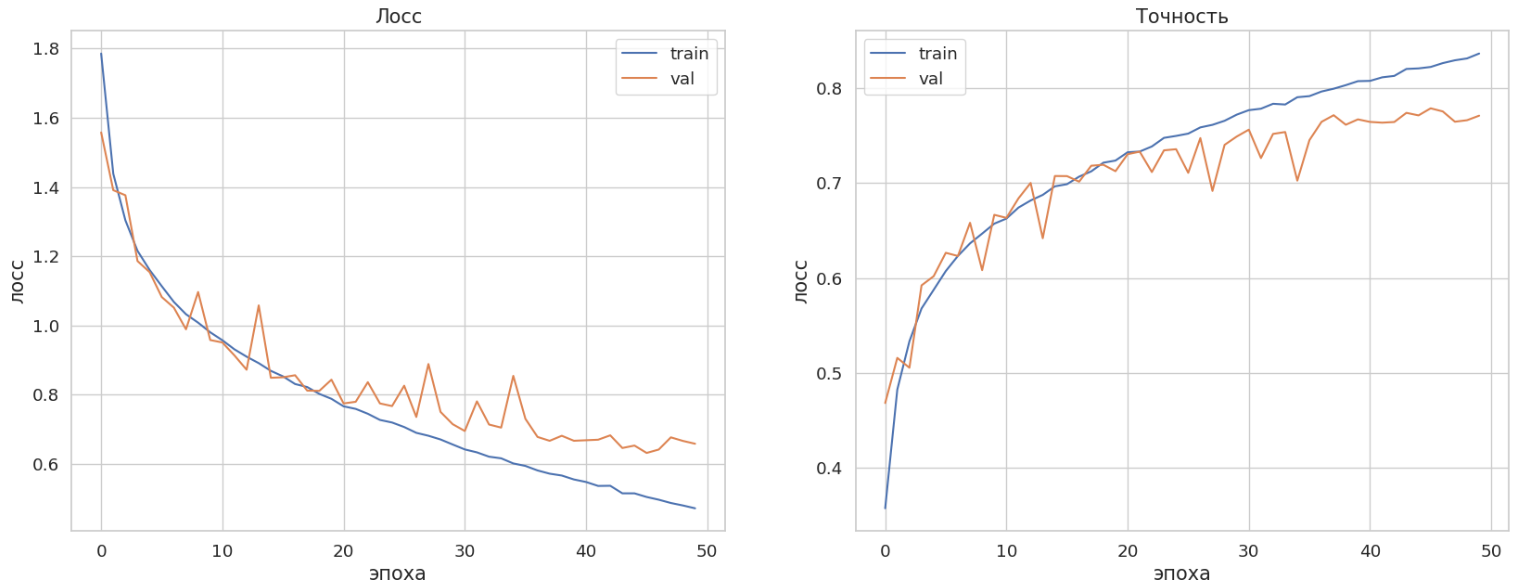

Далее отдельно рассмотрим, как можно применять предобученную нейронную сеть `resnet50` используя оба вышеупомянутых подхода. В целях экономии времени на семинаре, не запускайте ячейки с обучением в этом блоке. Все остальные ячейки можно смело запускать.

❗При использовании предобученных моделей нужно для начала изучать особенности их обучения. Например, при обучении `resnet50` использовалась следующая последовательность преобразований:

1. Ресайз изображения до размера 256 с помощью билинейной интерполяции
2. Центральная обрезка до размера 224
3. Перевод на отрезок [0.0, 1.0]
4. Нормализация со средним mean=[0.485, 0.456, 0.406] и дисперсией std=[0.229, 0.224, 0.225]

Рекомендуется делать эти же преобразования и при кастомном использовании `resnet50`. К счастью, они уже реализованы в torch:

In [ ]:
transform = torchvision.models.ResNet50_Weights.IMAGENET1K_V1.transforms()
transform

In [ ]:
# Загрузим часть данных для обучения
dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
# Разделим выборку на обучение и валидацию
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [40000, 10000])

# Загрузим тестеовую часть данных
test_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Посмотрим на упомянутые преобразования:

In [ ]:
sns.set_style(style='white')

fig, ax = plt.subplots(
    nrows=2, ncols=3, figsize=(8, 6),
    sharey=True, sharex=True
)

for fig_x in ax.flatten():
    idx = np.random.randint(low=0, high=6000)
    img, label = val_dataset[idx]
    fig_x.set_title(classes[val_dataset[idx][1]])
    fig_x.imshow(img.numpy().transpose((1, 2, 0)))

Что ж... странно, но создателям резнета виднее.

Инициализируем генераторы батчей:

In [ ]:
batch_size = 64

train_batch_gen = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_batch_gen = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_batch_gen = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Напишем функции для обучения и визуализации:

In [ ]:
def plot_learning_curves(history):
    '''
    Функция для вывода лосса и метрики во время обучения.

    :param history: (dict)
        accuracy и loss на обучении и валидации
    '''
    # sns.set_style(style='whitegrid')
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Точность', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.ylabel('точность', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()
    plt.show()


def train(
    model,
    criterion,
    optimizer,
    train_batch_gen,
    val_batch_gen,
    num_epochs=50
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.

    :param model: обучаемая модель
    :param criterion: функция потерь
    :param optimizer: метод оптимизации
    :param train_batch_gen: генератор батчей для обучения
    :param val_batch_gen: генератор батчей для валидации
    :param num_epochs: количество эпох

    :return: обученная модель
    :return: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        start_time = time.time()

        # Устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True)

        # На каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:

            # Обучаемся на батче (одна "итерация" обучения нейросети)
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            # Логиты на выходе модели
            logits = model(X_batch)

            # Подсчитываем лосс
            loss = criterion(logits, y_batch.long().to(device))

            # Обратный проход
            loss.backward()
            # Шаг градиента
            optimizer.step()
            # Зануляем градиенты
            optimizer.zero_grad()

            # Сохраяняем лоссы и точность на трейне
            train_loss += loss.detach().cpu().numpy()
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # Подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen)
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)

        # Устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False)

        # Полный проход по валидации
        with torch.no_grad():
            for X_batch, y_batch in val_batch_gen:

                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

                # Логиты, полученные моделью
                logits = model(X_batch)

                # Лосс на валидации
                loss = criterion(logits, y_batch.long().to(device))

                # Сохраяняем лоссы и точность на валидации
                val_loss += loss.detach().cpu().numpy()
                y_pred = logits.max(1)[1].detach().cpu().numpy()
                val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # Подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen)
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)

        clear_output()

        # Печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))

        plot_learning_curves(history)

    return model, history

#### 2.3.1 Fine Tuning (с полной разморозкой)

Добавляем новые слои классификации под датасет CIFAR10:

In [ ]:
fine_tuning_model = nn.Sequential()

# предобученная на датасете ImageNet нейросеть ResNet50
fine_tuning_model.add_module('resnet', resnet50(pretrained=True))

# добавляем 2 FC слоя после выходов предобученной неросети
fine_tuning_model.add_module('relu_1', nn.ReLU())
fine_tuning_model.add_module('fc_1', nn.Linear(1000, 512))
fine_tuning_model.add_module('relu_2', nn.ReLU())
fine_tuning_model.add_module('fc_2', nn.Linear(512, 10))

# чистка видеокарты
torch.cuda.empty_cache()
gc.collect()

fine_tuning_model = fine_tuning_model.to(device)

Убедимся, что все параметры сети "разморожены", то есть являются обучаемыми:

In [ ]:
for param in fine_tuning_model.parameters():
    assert(param.requires_grad)
    assert(param.is_cuda)

**✏️ Замечание-рекомендация✏️**

Когда запускаете обучение тяжёлой модели, может возникнуть ошибка:

```
OutOfMemoryError: CUDA out of memory.
```
Это значит что вы исчерпали всю предоставленную вам оперативную память GPU. В таком случае:


1. Убедитесь, что вы зануляете градиенты после очередного шага оптимизатора и оборачиваете валидацию в тело "`with torch.no_grad():`"
2.   Перезапустите среду выполнения. Возможно, после предыдущего запуска, в результате, например, аварийного завершения или ещё по каким-то причинам, на видеокарте остались старые данные.
3. Для уверенности, что перед обучением на видеокарте точно нет мусора, очищайте кэш:


```
import gc
torch.cuda.empty_cache()
gc.collect()
```



Зафайнтюним наконец получившуюся модель на наших данных:

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fine_tuning_model.parameters(), lr=0.01)

fine_tuning_model, history = train(
    fine_tuning_model, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=5
)

Сделайте вывод, сравните с обучением собственной свёрточной нейросети с прошлого семинара.

**Вывод:**

#### 2.3.2 Feature Extractor (с практически полной заморозкой).
Импортируем ResNet заново:

In [ ]:
feature_extractor_model = resnet50(pretrained=True)

"Замораживаем" все веса всех слоев:

In [ ]:
for param in feature_extractor_model.parameters():
    param.requires_grad = False

Последний слой ResNet50 переводит выход основной части модели в вектор размерности 1000:

In [ ]:
feature_extractor_model.fc

У нас классов всего 10, поэтому заменим последний слой, сделав его обучаемым:

In [ ]:
feature_extractor_model.fc = nn.Linear(2048, len(classes))
feature_extractor_model.fc

In [ ]:
for param in feature_extractor_model.fc.parameters():
  assert param.requires_grad

Снова инициализируем даталоадеры, так как они являются генераторами:

In [ ]:
train_batch_gen = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_batch_gen = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
plt.imshow(val_dataset[0][0].numpy().transpose((1, 2, 0)))

Дообучим ResNet под наши данные:

In [ ]:
torch.cuda.empty_cache()
gc.collect()

feature_extractor_model = feature_extractor_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(feature_extractor_model.parameters(), lr=0.01)

feature_extractor_model, history = train(
    feature_extractor_model, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=20
)

Какой метод, как вам кажется, дал лучшие результаты? Напишите свои мысли.

#### 2.3 Практика по transfer learning

Скачайте предобученную `resnet18` и используйте ее в качестве feature extractor.

In [ ]:
# импортируйте модель и посмотрите на её структуру

In [ ]:
transform = torchvision.models.ResNet18_Weights.IMAGENET1K_V1.transforms()

Снова загрузите датасет и инициализируйте даталоадеры:

Создайте модель обучите её на ОДНОМ БАТЧЕ.

Сделайте предсказания на одном батче из тестовой выборки, выведите сетку картинок 8х8 и укажите на ней предсказанные классы и истинные.

Достать батч можно следующим образом: `next(iter(test_batch_gen))`, а убрать назойливые числа на осях при помощи `plt.axis("off")`.

Не забудьте, что картинку для предсказания также необходимо преобразовывать.

In [ ]:
model.train(False)

**Вывод:**